In [2]:
import matplotlib.pyplot as plt
import numpy
import pandas
import tqdm

import hetmech.hetmat
import hetmech.degree_group
import hetmech.degree_weight
import hetmech.pipeline

%matplotlib inline

In [3]:
hetmat = hetmech.hetmat.HetMat('../../data/hetionet-v1.0.hetmat/')

In [4]:
metapaths = ['DaGbC', 'SpDpS', 'SEcCrCtD', 'CiPCiCtD']

In [5]:
bins = numpy.linspace(0, 1, 101)
bin_counts = {metapath: pandas.DataFrame() for metapath in metapaths}

## Compute p-values for the actual HetMat

In [4]:
hetmat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(hetmat, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = hetmat.get_path_counts_path(metapath, 'dwpc', 0, None)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    
hetmat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(hetmat, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = hetmat.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)

100%|██████████| 4/4 [00:00<00:00, 22.07it/s]


In [5]:
for name, permat in tqdm.tqdm((hetmat.permutations.items())):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=10)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = hetmat.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = hetmat.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = hetmat.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


In [6]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(hetmat, metapath, damping=0.5, ignore_zeros=False, max_p_value=1.0)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

100%|██████████| 4/4 [01:11<00:00, 17.88s/it]


## Compute p-values for a permat - Permutation 1

In [7]:
perms = hetmat.permutations.copy()
permat_1 = perms.pop('001')

In [8]:
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    del pc_matrix
    
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)
    del dwpc_matrix

100%|██████████| 4/4 [00:00<00:00, 16.53it/s]


In [9]:
for name, permat in tqdm.tqdm(perms.items()):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=16)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        path.parent.mkdir(parents=True, exist_ok=True)
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

100%|██████████| 199/199 [02:51<00:00,  1.16it/s]


In [10]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(permat_1, metapath, damping=0.5, ignore_zeros=False, max_p_value=1.0)
    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    path.parent.mkdir(parents=True, exist_ok=True)
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

100%|██████████| 4/4 [01:10<00:00, 17.71s/it]


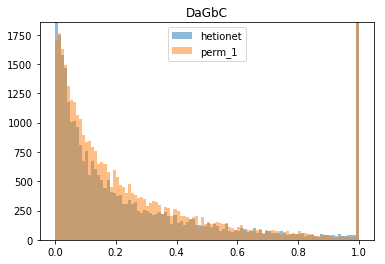

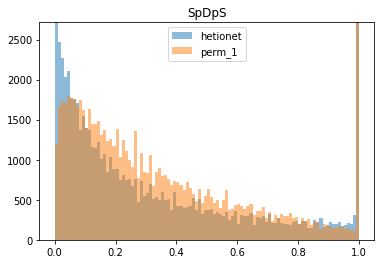

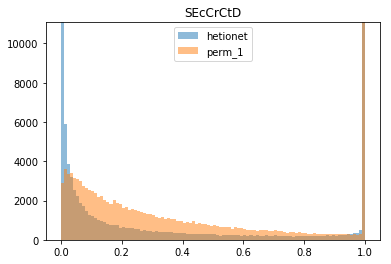

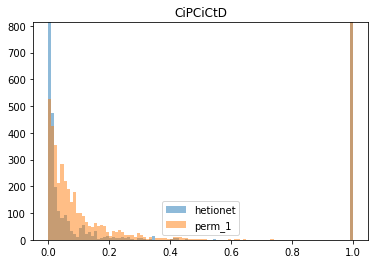

In [8]:
for metapath in metapaths:
    plt.figure()
    plt.title(metapath)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    bins_het, _, _ = plt.hist(df['p_value'], label='hetionet', alpha=0.5, bins=bins)
    
    bin_counts[metapath]['bins'] = bins[:-1]
    bin_counts[metapath]['hetionet'] = bins_het

    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    counts, _, _ = plt.hist(df['p_value'], label='perm_1', alpha=0.5, bins=bins)
    bin_counts[metapath]['perm_1'] = counts
    plt.ylim((0, max(bins_het[:-1])))
    plt.legend();

### Permutation 2

In [9]:
perms = hetmat.permutations.copy()
permat_1 = perms.pop('002')

In [13]:
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    del pc_matrix
    
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)
    del dwpc_matrix

100%|██████████| 4/4 [00:00<00:00, 17.23it/s]


In [14]:
for name, permat in tqdm.tqdm(perms.items()):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=16)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        path.parent.mkdir(parents=True, exist_ok=True)
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

100%|██████████| 199/199 [02:52<00:00,  1.15it/s]


In [15]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(permat_1, metapath, damping=0.5, ignore_zeros=False, max_p_value=1.0)
    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    path.parent.mkdir(parents=True, exist_ok=True)
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

100%|██████████| 4/4 [01:09<00:00, 17.42s/it]


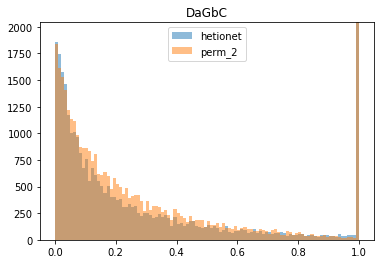

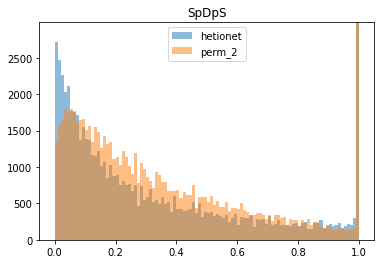

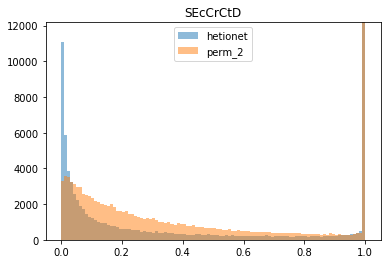

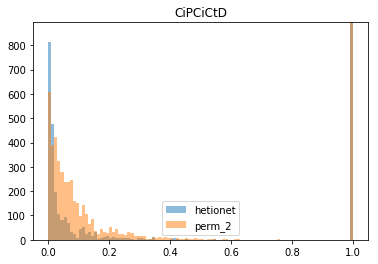

In [10]:
for metapath in metapaths:
    plt.figure()
    plt.title(metapath)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    bins_het, _, _ = plt.hist(df['p_value'], label='hetionet', alpha=0.5, bins=bins)

    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    counts, _, _ = plt.hist(df['p_value'], label='perm_2', alpha=0.5, bins=bins)
    bin_counts[metapath]['perm_2'] = counts
    plt.ylim((0, 1.1 * max(bins_het[:-1])))
    plt.legend();

### Permutation 150

In [11]:
perms = hetmat.permutations.copy()
permat_1 = perms.pop('150')

In [18]:
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0, dense_threshold=0.7, dtype='uint64')
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(pc_matrix, path)
    del pc_matrix
    
permat_1.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat_1, allocate_GB=10)
mean_dwpcs = dict()
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmech.degree_weight.dwpc(permat_1, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')
    mean_dwpcs[(metapath, 'dwpc', 0.5)] = dwpc_matrix.mean()
    path = permat_1.get_path_counts_path(metapath, 'dwpc', 0.5, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmech.hetmat.save_matrix(dwpc_matrix, path)
    del dwpc_matrix

100%|██████████| 4/4 [00:00<00:00, 17.02it/s]


In [19]:
for name, permat in tqdm.tqdm(perms.items()):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=16)
    for metapath in metapaths:
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=mean_dwpcs[(metapath, 'dwpc', 0.5)], damping=0.5)
        path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
        path.parent.mkdir(parents=True, exist_ok=True)
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.path_counts_cache = None

# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = permat_1.get_running_degree_group_path(metapath, 'dwpc', 0.5, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

100%|██████████| 199/199 [02:50<00:00,  1.17it/s]


In [21]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(permat_1, metapath, damping=0.5, ignore_zeros=False, max_p_value=1.0)
    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    path.parent.mkdir(parents=True, exist_ok=True)
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')

100%|██████████| 4/4 [01:09<00:00, 17.38s/it]


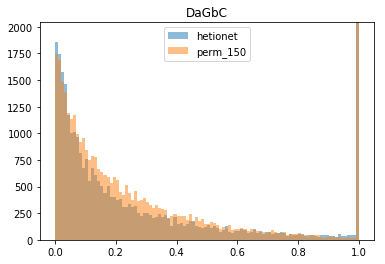

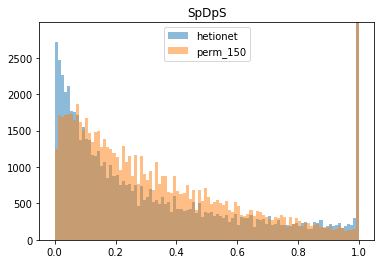

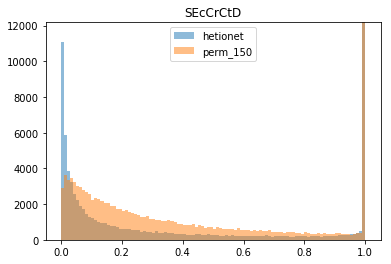

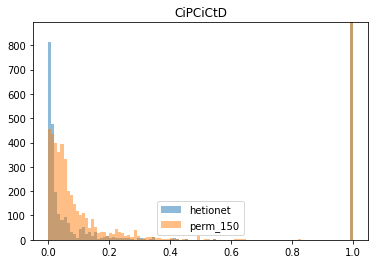

In [12]:
for metapath in metapaths:
    plt.figure()
    plt.title(metapath)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                     'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    bins_het, _, _ = plt.hist(df['p_value'], label='hetionet', alpha=0.5, bins=bins)
    
    path = permat_1.directory.joinpath('adjusted-path-counts', 'dwpc-0.5',
                                       'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    counts, _, _ = plt.hist(df['p_value'], label='perm_150', alpha=0.5, bins=bins)
    bin_counts[metapath]['perm_150'] = counts
    plt.ylim((0, 1.1 * max(bins_het[:-1])))
    plt.legend();

In [31]:
complete_df = None
for key, df in bin_counts.items():
    df = df.assign(metapath=key)
    if complete_df is None:
        complete_df = df
    else:
        complete_df = complete_df.append(df)

columns = [complete_df.columns[-1]] + list(complete_df.columns[0:-1])
complete_df = complete_df[columns]
complete_df[columns[-4:]] = complete_df[columns[-4:]].astype(int)
complete_df.to_csv(path_or_buf=f'bin_counts.tsv', sep='\t', index=False, float_format='%.2f')